### Training 

The spiking restricted Boltzmann machine is trained with data similar to the one used by Finnegan et al. (2015)

/opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



Please run the data generation file if not done so yet!!

Number of seed patterns:                      5
Number of prototypes per seed patterns        10
Number of prototypes total:                   50
Number of variations per prototype            10
Number of patterns total                      500
Number of input neurons (stimulus length):    100
Number of hidden neurons:                     500
Number of class neurons:                      0
Number of class neurons per class:            0
Matched
[[0.    0.    0.    0.    0.   ]
 [0.07  0.    0.    0.    0.   ]
 [0.06  0.05  0.    0.    0.   ]
 [0.05  0.055 0.035 0.    0.   ]
 [0.04  0.03  0.03  0.025 0.   ]]


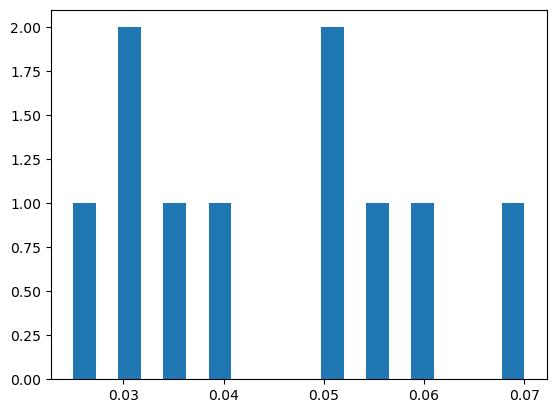

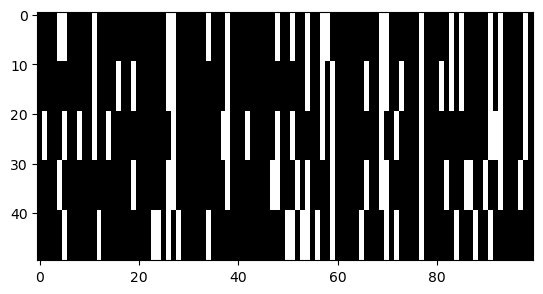

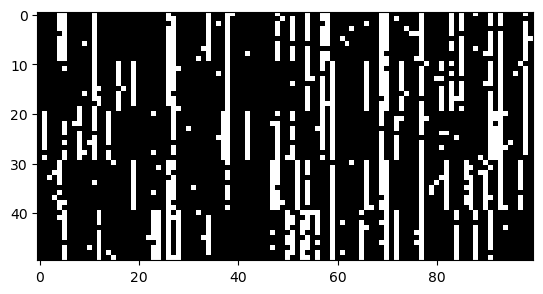

In [1]:
# Imports
import numpy as np 
from tools.srbm import *          
from tools.functions import *
import matplotlib.pyplot as plt
from brian2tools import *
from tools.parameters import *
from generate_data import *
import glob

In [2]:
# Description of condition to simulate: 
save_output = True # save the output of the simulation

### !!!!! sparseness is changed in srbm code !!!!! ### --> ITS CHANGED BACK NOW!!!

condition = "sparse_015_015_neurogenesis_leak_adj_turnover" # name of the condition

# If the file is runed several times, automatically the output will be incremented by one with the pattern: 
# n-condition.pkl, where n is the number of the output file.
saving_path = "output.nosync/"

# Loading the data
data_finnegan = load_data("data_uniform_variations_100", path = "training_data/")

Data loaded from training_data/data_uniform_variations_100.pkl



Variations per prototype in train set after train-test-split: 9
Variations per prototype in test set after train-test-split:  1

Each group consists of 45 randomized patterns. 
The patterns for the first group consist of the 9 variations of the first of the 10 prototypes 
that were generated for each of the 5 seed patterns. 
Practically, that means that the first group consists of the 9 variations of the first prototype 
generated of the first seed pattern + the 9 variations of the first prototype generated of the second 
seed pattern, etc., making 45 patterns in total. 
The second group consists of the 9 variations of the second prototype generated of the first seed 
pattern + the 9 variations of the second prototype generated of the second seed pattern, etc.


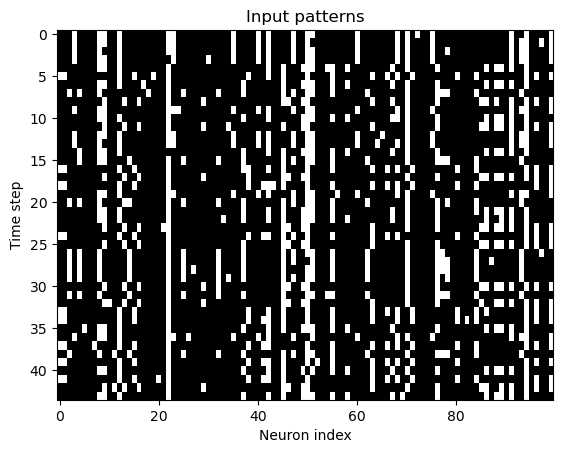

The input patterns are shown above. 
After each group of 45 patterns, test patterns for each prototype are shown. 
In the end all test patterns are shown. 



In [3]:
# Some parameters for training the SRBM - the others are in paramters_main.py

T = dcmt*t_ref
init_delay=dcmt*t_ref
delay=0*ms

n_samples = 1000

train_test_data = train_test_split_finnegan(data_finnegan, 0.9)

print("\nVariations per prototype in train set after train-test-split: " + str(len(train_test_data[0][0])))
print("Variations per prototype in test set after train-test-split:  " + str(len(train_test_data[1][0])))

off_time = 1 # How many frames should be after a test pattern before the next test pattern is presented?

# Create the Ids. Test patterns are not randomized!
Ids, time_test_on, time_test_off = create_finnegan_Ids(train_test_data, off_time = 1)

print("\nEach group consists of " + str(len(train_test_data[0][0]) * n_seed_patterns) + " randomized patterns. \n" +
      "The patterns for the first group consist of the " + str(len(train_test_data[0][0])) + " variations of " + 
      "the first of the " + str(n_prototype_per_seed) +  " prototypes \nthat were generated for each of the " + str(n_seed_patterns) + " seed patterns. \n" + 
      "Practically, that means that the first group consists of the 9 variations of the first prototype \n" + 
      "generated of the first seed pattern + the 9 variations of the first prototype generated of the second \n" + 
      "seed pattern, etc., making " + str(len(train_test_data[0][0]) * n_seed_patterns) + " patterns in total. \n" + 
      "The second group consists of the 9 variations of the second prototype generated of the first seed \n" + 
      "pattern + the 9 variations of the second prototype generated of the second seed pattern, etc.")

fig, ax = plt.subplots()
plt.imshow(Ids[1:45], cmap='gray', aspect='auto', interpolation= "None")
plt.xlabel("Neuron index")
plt.ylabel("Time step")
plt.title("Input patterns")
plt.show()
print("The input patterns are shown above. \n" +
      "After each group of " + str(len(train_test_data[0][0]) * n_seed_patterns) + " patterns, test patterns for each prototype are shown. \n" + 
      "In the end all test patterns are shown. \n")



In [4]:
## shorten ids for trials!
#Ids = Ids[0:50] *0 
#Ids = np.repeat(Ids[1], 30).reshape(200, 30).T

In [5]:
# Create the parameters for the SRBM
W, b_v, b_c, b_h = create_rbm_parameters(N_v = N_v, N_c = N_c, N_h = N_h)

# Create timepoints for classificaiton
# One timepoint for each input pattern. Starts with timepoint 1
timepoints, t_sim, time_points_dict = create_timepoints(Ids, init_delay, delay, T)

# Calculate simulation time for accurate neural growth
sim_time = (t_sim / (dcmt*t_ref))

In [6]:
# SRBM main function
# leak helper is sensistivity ov average
print("Starting the SRBM simulation...")
out = main(W, b_v, b_c, b_h, Id = Ids, sim_time = sim_time, t_sim = t_sim, dorun = True, n_classes = 5,
           monitors = True, display=False, # set display to false if no lables are used 
           # Ageing parameters:
           p_target = 1e-10 , sparsity_cost = 0.15 , # sparsity cost in learning equation. Multiply by 0 to turn off.
           leak_helper = 10, # how reactive is the helper neuron that determines the average firing rate of the hidden neurons (for the sparsity cost)
           age_neurons = True, # Should the network age in any way?
           age_leak = True, # Should the leak conductance depend on the age of the neuron?
           age_threshold= False, # Should the threshold depend on the age of the neuron?
           threshold_ageing_degree = 0.2, # How much should the threshold depend on the age of the neuron?
           set_connectivity = True, # Should the connectivity be controlled?
           connectivity_born=0.01, connectivity_mature=0.05, # How connected are the neurons at the beginning and at the end of their life? If the same number is given, the connectivity is constant.
           neurogenesis = True, # Should new neurons be born?
           generations = 4, # How often are neurons reborn? Only matters if tunrover is True!
           turnover=True, # Should neurons die?
           prop_born= 0.15, # How many neurons are yet to be born thoughout the whole simulation? Only matters if turnover is True!
           gompertz=[0, 1], # horizontal shift, growth rate
           apt_wt_str = 0.25, apt_diff = 0.6, apt_age = 0.15, # weight of weight strength and differntiation and age on p_aptosis
           n_percent_apoptosis = 0.1, # fraction of neurons in aptosis ranking (between 0 and 1)
           ) 
locals().update(out)

Starting the SRBM simulation...
ageing factor:  0.20481310803891467


INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_3l1axzjq/var
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_3l1axzjq/var/folders
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_3l1axzjq/var/folders/07
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_3l1axzjq/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_3l1axzjq/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_3l1axzjq/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_3l1axzjq
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include -arch arm64 -fPIC -O2 -isystem /opt/homebrew

Starting simulation at t=0. s for a duration of 78.12 s
2.263 s (2%) simulated in 10s, estimated 5m 35s remaining.
4.5589 s (5%) simulated in 20s, estimated 5m 23s remaining.
6.8449 s (8%) simulated in 30s, estimated 5m 12s remaining.
9.1633 s (11%) simulated in 40s, estimated 5m 1s remaining.
11.4853 s (14%) simulated in 50s, estimated 4m 50s remaining.
13.7413 s (17%) simulated in 1m 0s, estimated 4m 41s remaining.
16.0561 s (20%) simulated in 1m 10s, estimated 4m 31s remaining.
18.3733 s (23%) simulated in 1m 20s, estimated 4m 20s remaining.
20.6713 s (26%) simulated in 1m 30s, estimated 4m 10s remaining.
22.9909 s (29%) simulated in 1m 40s, estimated 4m 0s remaining.
25.3093 s (32%) simulated in 1m 50s, estimated 3m 50s remaining.
27.3325 s (34%) simulated in 2m 0s, estimated 3m 43s remaining.
29.6578 s (37%) simulated in 2m 10s, estimated 3m 32s remaining.
31.9753 s (40%) simulated in 2m 20s, estimated 3m 22s remaining.
34.2899 s (43%) simulated in 2m 30s, estimated 3m 12s remaini

In [7]:
Mh, Mv, Mc= out['Mh'], out['Mv'], out['Mc']
sMhh_age = out["sMhh_age"]
sMhh_av_act = out["sMhh_av_act"]
sMh_age = out["sMh_age"]
sMh_v = out["sMh_v"]
sMhh_age = out["sMhh_age"]
sMh_q = out["sMh_q"]
weights = out["weights"]
connections = out["connections"]
average_weigth_strenght = out["av_wt_str"]
differenti = out["differentiat"]
check = out["check"]

In [8]:
# Optionally save all the weights to a csv file
""" import pandas as pd
df = pd.DataFrame(weights)
df.to_csv("weights.csv") """

' import pandas as pd\ndf = pd.DataFrame(weights)\ndf.to_csv("weights.csv") '

In [9]:
""" plt.imshow(weights[40].reshape(100, 500).T, interpolation="None")
plt.show()  
plt.imshow(connections[40].reshape(100, 500).T, interpolation="None")
plt.show() """

' plt.imshow(weights[40].reshape(100, 500).T, interpolation="None")\nplt.show()  \nplt.imshow(connections[40].reshape(100, 500).T, interpolation="None")\nplt.show() '

In [10]:
""" t_start = 5
t_stop = 40
precision = 1
idx_start = np.where(np.round(Mh.t, precision) == np.round(time_points_dict["T"+str(t_start)+"_s"]/second, precision))[0][0]
idx_stop = np.where(np.round(Mh.t, precision) == np.round(time_points_dict["T"+str(t_stop)+"_e"]/second-0.01, precision))[0][0]
plot_raster(Mh.i[idx_start:idx_stop], Mh.t[idx_start:idx_stop], markersize=2,marker='|', color='k', mew=1)
plt.show()
#plt.savefig('early_spikes_hidden.pdf')

neuron_id = 4
spike_count = len(Mh.t[idx_start:idx_stop][Mh.i[idx_start:idx_stop] == neuron_id])
print("Spike count for neuron " + str(neuron_id) + " during interval " + str(t_start) + " to " + str(t_stop) + ": " + str(spike_count))
 """

# Some plots - use only with small trial sets!
""" n_neurons = 20
for i in np.arange(n_neurons):
    plt.plot(sMh_age.t/ms, sMh_age.age[i], linewidth=1) 
plt.ylim(-0.2, 1.2)

plt.show() 
 """

' n_neurons = 20\nfor i in np.arange(n_neurons):\n    plt.plot(sMh_age.t/ms, sMh_age.age[i], linewidth=1) \nplt.ylim(-0.2, 1.2)\n\nplt.show() \n '

In [11]:
""" t_start = 525
t_stop = 530
precision = 1
idx_start = np.where(np.round(Mv.t, precision) == np.round(time_points_dict["T"+str(t_start)+"_s"]/second, precision))[0][0]
idx_stop = np.where(np.round(Mv.t, precision) == np.round(time_points_dict["T"+str(t_stop)+"_e"]/second-0.01, precision))[0][0]
plot_raster(Mv.i[idx_start:idx_stop], Mv.t[idx_start:idx_stop], markersize=2,marker='|', color='k', mew=1)
plt.show()
#plt.savefig('late_spikes_visible.pdf') """

' t_start = 525\nt_stop = 530\nprecision = 1\nidx_start = np.where(np.round(Mv.t, precision) == np.round(time_points_dict["T"+str(t_start)+"_s"]/second, precision))[0][0]\nidx_stop = np.where(np.round(Mv.t, precision) == np.round(time_points_dict["T"+str(t_stop)+"_e"]/second-0.01, precision))[0][0]\nplot_raster(Mv.i[idx_start:idx_stop], Mv.t[idx_start:idx_stop], markersize=2,marker=\'|\', color=\'k\', mew=1)\nplt.show()\n#plt.savefig(\'late_spikes_visible.pdf\') '

In [12]:
""" n_neurons = 1
start = 4000
stop =5000
for i in np.arange(n_neurons):
    plt.plot(sMhh_av_act.t[start:stop]/ms, sMh_v.v[i][start:stop], label='Neuron ' + str(i), linewidth=0.5)
plt.legend(loc=2, prop={'size': 8})

plt.show() """


" n_neurons = 1\nstart = 4000\nstop =5000\nfor i in np.arange(n_neurons):\n    plt.plot(sMhh_av_act.t[start:stop]/ms, sMh_v.v[i][start:stop], label='Neuron ' + str(i), linewidth=0.5)\nplt.legend(loc=2, prop={'size': 8})\n\nplt.show() "

In [13]:
""" plt.plot(sMhh_av_act.t/ms, sMhh_av_act.q[0], label='Neuron ' + str(i), linewidth=0.5)
#plt.ylim(0, 0.01)
#plt.legend(loc=2, prop={'size': 8})

plt.show() """


" plt.plot(sMhh_av_act.t/ms, sMhh_av_act.q[0], label='Neuron ' + str(i), linewidth=0.5)\n#plt.ylim(0, 0.01)\n#plt.legend(loc=2, prop={'size': 8})\n\nplt.show() "

In [14]:
# Prepare weights and biases
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta_parameter
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta_parameter*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta_parameter*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

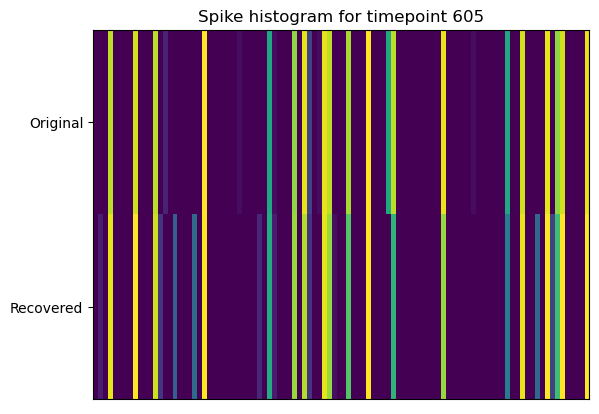

In [15]:
timepoint = 605 # for which timepoint should the spike histogram be plotted?

t_start_stimulus = time_points_dict["T"+ str(timepoint)+"_s"]
t_stop_stimulus = time_points_dict["T"+ str(timepoint)+"_e"]
t_start_recover = time_points_dict["T"+ str(timepoint+1)+"_s"]
t_stop_recover = time_points_dict["T"+ str(timepoint+off_time)+"_e"]
orig = spike_histogram(Mv, t_start=t_start_stimulus, t_stop=t_stop_stimulus).T[1]
recover = spike_histogram(Mv, t_start=t_start_recover+0.01*second, t_stop=t_stop_recover).T[1]

fig, ax = plt.subplots()
plt.imshow(np.row_stack((normalizer(orig), normalizer(recover))), aspect='auto', interpolation= "None")
plt.yticks(np.linspace(0, 1, 2),["Original", "Recovered"])
plt.title("Spike histogram for timepoint " + str(timepoint))
ax.set_xticks([])
plt.show()

In [16]:
# Function to save the output of the SRBM simulation
def save_output(unique = "", date = "", path = "output/"):
    '''Saves the output of the SRBM simulation in a pickle file.'''
    import pickle
    k_v, v_v = zip(*Mv.spike_trains().items())
    k_h, v_h = zip(*Mh.spike_trains().items())
    output = {"Mv": {"i":np.array(Mv.i), "t":np.array(Mv.t), 
                     "k": k_v, "v": v_v}, 
              "Mh": {"i":np.array(Mh.i), "t":np.array(Mh.t), 
                     "k": k_h, "v": v_h},
              "time_test_on":time_test_on,
              "time_test_off":time_test_off,
              "Ids":Ids,
              "timepoints":timepoints,
              "t_sim":t_sim,
              "time_points_dict":time_points_dict,
              "W":W,
              "b_v":b_v,
              "b_c":b_c,
              "b_h":b_h,
              "mB":mB,
              "Wvh":Wvh,
              "Wch":Wch,
              "mBv":mBv,
              "mBh":mBh,
              "sim_time":sim_time,
              "N_v":N_v,
              "N_c":N_c,
              "N_h":N_h,
              "beta_parameter":beta_parameter,
              "tau_rec":tau_rec,
              "dcmt":dcmt,
              "off_time":off_time,
              "n_seed_patterns": n_seed_patterns,
              "n_prototype_per_seed": n_prototype_per_seed,
              "n_variations_per_prototype": n_variations_per_prototype, 
              "after_split_n_per_prototype_train": len(train_test_data[0][0]), 
              "after_split_n_per_prototype_test": len(train_test_data[1][0])}                                 
    with open(path+unique+date+'.pkl', 'wb') as handle: # Python 3:
        pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Output saved as output/"+unique+date+".pkl")

In [17]:
# find following number for new output

existing_condition_numbers = glob.glob(saving_path + "*" + condition + ".pkl")

nums = []
for i in existing_condition_numbers:
    if i[len(saving_path):][:-4].split("-")[1] == condition:
        nums.append(int(i[len(saving_path):].split("-")[0]))

if len(nums) == 0:
    new_num = 1
else:
    new_num = max(nums) + 1

# Save the output to open in the evaluation notebook
if save_output:
    save_output(unique = str(new_num) + "-" + condition, date = "", path = saving_path)

Output saved as output/10-sparse_015_015_neurogenesis_leak_adj_turnover.pkl
